# Welcome to `NeuroEvoBench` 👋 [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuroevobench/neuroevobench/blob/main/examples/neb_introduction.ipynb)

In the following mini-tutorial we walk through the core functionality of the `NeuroEvoBench` benchmark. More specifically, we show how to run a random search sweep using a Simple Evolution Strategy (ES) implemented in [`evosax`](https://github.com/RobertTLange/evosax/) on a set of simple (and fast to evaluate) BBOB functions. All of the task evaluations follow the same protocol. Let's start by importing the benchmark and `evosax`.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

try:
    import evosax
    import neuroevobench
except Exception:
    !pip install -q git+https://github.com/RobertTLange/evosax.git@main
    !pip install -q git+https://github.com/neuroevobench/neuroevobench.git@main
    !pip install --ignore-installed Pillow==9.0.0
    
    import evosax
    import neuroevobench

envpool not installed, Atari problems will not work.
envpool not installed, Atari problems will not work.
You need to install brax for Brax tasks:
  pip install git+https://github.com/google/brax.git@main


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Evolution Strategy Setup & `evosax` API 

In [2]:
import jax
import jax.numpy as jnp
from evosax import SimpleES

# Instantiate the evolution strategy instance
strategy = SimpleES(num_dims=2, popsize=10)

# Get default hyperparameters (e.g. lrate, etc.)
es_params = strategy.default_params
es_params = es_params.replace(init_min= -3, init_max=3)

# Initialize the strategy
rng = jax.random.PRNGKey(0)
state = strategy.initialize(rng, es_params)

# Have a look at the hyperparameters (change if desired)
es_params

EvoParams(c_sigma=0.1, c_m=1.0, sigma_init=1.0, init_min=-3, init_max=3, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

# `BBOB` task setup & running a single eval

In [3]:
from neuroevobench.problems.bbob import BBOBEvaluator

popsize = 10
num_dims = 2
es_config = {}
es_params = {}
num_eval_runs = 5
seed_id = 42
num_generations = 50


# 1. Setup task evaluator with strategy
evaluator = BBOBEvaluator(
    popsize=popsize,
    num_dims=num_dims,
    es_strategy=SimpleES,
    es_config=es_config,
    es_params=es_params,
    num_eval_runs=num_eval_runs,
    seed_id=seed_id,
)

# 2. Run the ES loop with logging
evaluator.run(num_generations)

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50} {'Sphere_mean': DeviceArray(0.00208277, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.59280723, dtype=float32), 'Discus_mean': DeviceArray(3785.8782, dtype=float32), 'RastriginRotated_mean': DeviceArray(23.384197, dtype=float32), 'Schwefel_mean': DeviceArray(3.7671869, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(28.045166, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.550129, dtype=float32), 'Weierstrass_mean': DeviceArray(29.481977, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.54004943, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(14.863263, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(85.39087, dtype=float32), 'RastriginOriginal_mean': DeviceArray(23.81484, dtype=float32), 'LinearSlope_mean': DeviceArray(-266.49292, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(1.094798, dtype=float32), 'EllipsoidalRotated_mea

In [4]:
# Average task performance across all BBOB functions
evaluator.fitness_eval

-213.34922790527344

# Sequential Random Search Sweep

In [5]:
import copy
from mle_hyperopt import RandomSearch
from neuroevobench.problems import neb_eval_loops
from neuroevobench.hyperparams import HyperSpace

In [6]:
# Setup the strategy search space for sequential evaluation
hyperspace = HyperSpace(
    space={"real":
        {"sigma_init": {"begin": 0.01, "end": 0.5, "prior": "uniform"}}
    }
)

hyper_strategy = RandomSearch(
    **hyperspace.space,
    search_config={
        "refine_after": 40,
        "refine_top_k": 10
    },
    maximize_objective=True,
    seed_id=0,
    verbose=True,
)


from dotmap import DotMap
config = DotMap({
    "strategy_name": "SimpleES",
    "popsize": 10,
    "num_dims": 2,
    "es_config": {},
    "es_params": {},
    "num_eval_runs": 5,
    "seed_id": 42,
    "num_generations": 50
})

              MLE-Hyperopt Random Hyperspace 🚀                        
                                                                                
           🌻 Variable   Type   Search Range ↔                                  
          ────────────────────────────────────────────────────────────          
           sigma_init    real   Begin: 0.01, End: 0.5, Prior: uniform 

In [7]:
# Run the random search hyperparameter optimization loop
for search_iter in range(50):
    # Augment the default params with the proposed parameters
    proposal_params = hyper_strategy.ask()
    eval_config = copy.deepcopy(config)
    for k, v in proposal_params.items():
        eval_config.es_config[k] = v

    # Evaluate the parameter config by running a ES loop
    performance, solution = neb_eval_loops["bbob"](
        eval_config,
        log=None,
        search_iter=search_iter,
    )

    # Update search strategy - Note we minimize!
    hyper_strategy.tell(proposal_params, float(performance))

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 0} {'Sphere_mean': DeviceArray(0.00016203, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.27455124, dtype=float32), 'Discus_mean': DeviceArray(262.93015, dtype=float32), 'RastriginRotated_mean': DeviceArray(11.297349, dtype=float32), 'Schwefel_mean': DeviceArray(3.3801732, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(2.0099385, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.07498827, dtype=float32), 'Weierstrass_mean': DeviceArray(0.63930243, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.17726558, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.454251, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(20.129179, dtype=float32), 'RastriginOriginal_mean': DeviceArray(12.772013, dtype=float32), 'LinearSlope_mean': DeviceArray(-21.587547, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(3.9564817, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.29550186, dtype=float32), 'El

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 1   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 15:58:33 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 0  │ -21.575 │ 'sigma_init': 0.279                    │    
   │ Best in Batch │ 0  │ -21.575 │ 'sigma_init': 0.279                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 1} {'Sphere_mean': DeviceArray(0.00027059, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.3538096, dtype=float32), 'Discus_mean': DeviceArray(594.74286, dtype=float32), 'RastriginRotated_mean': DeviceArray(17.108307, dtype=float32), 'Schwefel_mean': DeviceArray(2.83757, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(2.1512241, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.11554252, dtype=float32), 'Weierstrass_mean': DeviceArray(1.4634793, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.14000084, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.836069, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(18.11529, dtype=float32), 'RastriginOriginal_mean': DeviceArray(12.940608, dtype=float32), 'LinearSlope_mean': DeviceArray(-49.27611, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.3231727, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.384131, dtype=float32), 'Ellipsoida

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 2   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 15:59:03 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 0  │ -21.575 │ 'sigma_init': 0.279                    │    
   │ Best in Batch │ 1  │ -34.405 │ 'sigma_init': 0.36                     │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 2} {'Sphere_mean': DeviceArray(0.0001942, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.31130585, dtype=float32), 'Discus_mean': DeviceArray(358.07855, dtype=float32), 'RastriginRotated_mean': DeviceArray(12.835216, dtype=float32), 'Schwefel_mean': DeviceArray(2.9397182, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-6.807995, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.07508777, dtype=float32), 'Weierstrass_mean': DeviceArray(0.54412144, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.2482125, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(7.413588, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(15.42706, dtype=float32), 'RastriginOriginal_mean': DeviceArray(10.985679, dtype=float32), 'LinearSlope_mean': DeviceArray(-30.565994, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.5632765, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.32640016, dtype=float32), 'Ellip

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 3   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 15:59:32 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 2  │ -20.566 │ 'sigma_init': 0.305                    │    
   │ Best in Batch │ 2  │ -20.566 │ 'sigma_init': 0.305                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 3} {'Sphere_mean': DeviceArray(0.0001598, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.24979298, dtype=float32), 'Discus_mean': DeviceArray(259.4808, dtype=float32), 'RastriginRotated_mean': DeviceArray(9.697973, dtype=float32), 'Schwefel_mean': DeviceArray(2.5447729, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(5.2353005, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.06899687, dtype=float32), 'Weierstrass_mean': DeviceArray(0.67652655, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.20517544, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(11.736759, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(17.226957, dtype=float32), 'RastriginOriginal_mean': DeviceArray(11.250839, dtype=float32), 'LinearSlope_mean': DeviceArray(-20.93347, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(3.6041582, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.29349658, dtype=float32), 'Ellip

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 4   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:00:01 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 2  │ -20.566 │ 'sigma_init': 0.305                    │    
   │ Best in Batch │ 3  │ -21.532 │ 'sigma_init': 0.277                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 4} {'Sphere_mean': DeviceArray(9.861084e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.25958535, dtype=float32), 'Discus_mean': DeviceArray(111.71133, dtype=float32), 'RastriginRotated_mean': DeviceArray(2.9296498, dtype=float32), 'Schwefel_mean': DeviceArray(2.101896, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(1.368709, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.04910212, dtype=float32), 'Weierstrass_mean': DeviceArray(0.53529125, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.17522562, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(12.614681, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(6.6613955, dtype=float32), 'RastriginOriginal_mean': DeviceArray(6.2121634, dtype=float32), 'LinearSlope_mean': DeviceArray(-0.7584179, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.2605404, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.13867703, dtype=float32), 'E

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 5   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:00:28 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 5} {'Sphere_mean': DeviceArray(0.00022201, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.29132554, dtype=float32), 'Discus_mean': DeviceArray(652.38855, dtype=float32), 'RastriginRotated_mean': DeviceArray(12.39189, dtype=float32), 'Schwefel_mean': DeviceArray(3.121177, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(10.0717125, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.09824301, dtype=float32), 'Weierstrass_mean': DeviceArray(0.33906385, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.2017144, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(6.403543, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(21.40122, dtype=float32), 'RastriginOriginal_mean': DeviceArray(21.23364, dtype=float32), 'LinearSlope_mean': DeviceArray(-37.743877, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.3231727, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.36435965, dtype=float32), 'Ellips

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 6   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:00:57 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 5  │ -35.766 │ 'sigma_init': 0.326                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 6} {'Sphere_mean': DeviceArray(0.0001049, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.23269546, dtype=float32), 'Discus_mean': DeviceArray(117.24387, dtype=float32), 'RastriginRotated_mean': DeviceArray(7.330785, dtype=float32), 'Schwefel_mean': DeviceArray(2.3668888, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-2.282684, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.04535997, dtype=float32), 'Weierstrass_mean': DeviceArray(0.18937294, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.1843955, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(10.316733, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(8.109244, dtype=float32), 'RastriginOriginal_mean': DeviceArray(6.098723, dtype=float32), 'LinearSlope_mean': DeviceArray(-3.0770617, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.2605404, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.11166365, dtype=float32), 'Ellips

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 7   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:01:26 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 6  │ -13.99  │ 'sigma_init': 0.224                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 7} {'Sphere_mean': DeviceArray(0.0004161, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.3204442, dtype=float32), 'Discus_mean': DeviceArray(784.27423, dtype=float32), 'RastriginRotated_mean': DeviceArray(16.46692, dtype=float32), 'Schwefel_mean': DeviceArray(3.0402076, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(15.003089, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.15439427, dtype=float32), 'Weierstrass_mean': DeviceArray(1.420051, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.38622415, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(13.053284, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(23.361307, dtype=float32), 'RastriginOriginal_mean': DeviceArray(18.989624, dtype=float32), 'LinearSlope_mean': DeviceArray(-78.66348, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.55102104, dtype=float32), 'Ellipso

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 8   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:01:54 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 7  │ -47.748 │ 'sigma_init': 0.447                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 8} {'Sphere_mean': DeviceArray(0.00048427, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.45827642, dtype=float32), 'Discus_mean': DeviceArray(528.646, dtype=float32), 'RastriginRotated_mean': DeviceArray(17.642885, dtype=float32), 'Schwefel_mean': DeviceArray(2.790366, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(3.714896, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.16452864, dtype=float32), 'Weierstrass_mean': DeviceArray(1.4863092, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.20941137, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(3.7961311, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(20.20664, dtype=float32), 'RastriginOriginal_mean': DeviceArray(14.773859, dtype=float32), 'LinearSlope_mean': DeviceArray(-90.627495, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.6387106, dtype=float32), 'Ellipsoi

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 9   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:02:24 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 8  │ -58.464 │ 'sigma_init': 0.482                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 9} {'Sphere_mean': DeviceArray(8.155926e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.2507878, dtype=float32), 'Discus_mean': DeviceArray(73.76293, dtype=float32), 'RastriginRotated_mean': DeviceArray(1.3062929, dtype=float32), 'Schwefel_mean': DeviceArray(2.3835824, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-1.8977839, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.04990822, dtype=float32), 'Weierstrass_mean': DeviceArray(0.44519624, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.10217263, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(7.4899764, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(6.8864884, dtype=float32), 'RastriginOriginal_mean': DeviceArray(5.9448113, dtype=float32), 'LinearSlope_mean': DeviceArray(5.933947, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.9312643, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.06621778, dtype=float32), 'El

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 10  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:02:53 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 9  │ -7.9    │ 'sigma_init': 0.198                    │    
   │ Best in Batch │ 9  │ -7.9    │ 'sigma_init': 0.198                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 10} {'Sphere_mean': DeviceArray(0.00032983, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.31064746, dtype=float32), 'Discus_mean': DeviceArray(363.70447, dtype=float32), 'RastriginRotated_mean': DeviceArray(16.659079, dtype=float32), 'Schwefel_mean': DeviceArray(2.6761699, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(0.29217932, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.12341143, dtype=float32), 'Weierstrass_mean': DeviceArray(1.4533625, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.1453896, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.276696, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(26.52162, dtype=float32), 'RastriginOriginal_mean': DeviceArray(21.510893, dtype=float32), 'LinearSlope_mean': DeviceArray(-62.013294, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.1796329, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.5495786, dtype=float32), 'Elli

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 11  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:03:22 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 9  │ -7.9    │ 'sigma_init': 0.198                    │    
   │ Best in Batch │ 10 │ -30.34  │ 'sigma_init': 0.398                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 11} {'Sphere_mean': DeviceArray(0.00015089, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.25959837, dtype=float32), 'Discus_mean': DeviceArray(277.515, dtype=float32), 'RastriginRotated_mean': DeviceArray(6.3211327, dtype=float32), 'Schwefel_mean': DeviceArray(2.4839108, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(13.334495, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.06166889, dtype=float32), 'Weierstrass_mean': DeviceArray(0.4186314, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.17961015, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.496559, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(12.46865, dtype=float32), 'RastriginOriginal_mean': DeviceArray(5.084898, dtype=float32), 'LinearSlope_mean': DeviceArray(-18.272669, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.602425, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.22411914, dtype=float32), 'Ellipso

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 12  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:03:51 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 9  │ -7.9    │ 'sigma_init': 0.198                    │    
   │ Best in Batch │ 11 │ -18.18  │ 'sigma_init': 0.269                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 12} {'Sphere_mean': DeviceArray(0.00017316, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.2549316, dtype=float32), 'Discus_mean': DeviceArray(325.79294, dtype=float32), 'RastriginRotated_mean': DeviceArray(10.181204, dtype=float32), 'Schwefel_mean': DeviceArray(2.4282892, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(9.361792, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.05848004, dtype=float32), 'Weierstrass_mean': DeviceArray(0.4511353, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.1709491, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(1.7135333, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(19.518482, dtype=float32), 'RastriginOriginal_mean': DeviceArray(10.588834, dtype=float32), 'LinearSlope_mean': DeviceArray(-24.788006, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4197363, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.3038123, dtype=float32), 'Ellip

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 13  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:04:19 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 9  │ -7.9    │ 'sigma_init': 0.198                    │    
   │ Best in Batch │ 12 │ -20.275 │ 'sigma_init': 0.288                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 13} {'Sphere_mean': DeviceArray(0.00044753, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.3119727, dtype=float32), 'Discus_mean': DeviceArray(435.7115, dtype=float32), 'RastriginRotated_mean': DeviceArray(19.799215, dtype=float32), 'Schwefel_mean': DeviceArray(2.8740168, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(6.3919387, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.14154534, dtype=float32), 'Weierstrass_mean': DeviceArray(2.3930218, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.32094097, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(10.450421, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(18.926971, dtype=float32), 'RastriginOriginal_mean': DeviceArray(16.90872, dtype=float32), 'LinearSlope_mean': DeviceArray(-84.29246, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.6183284, dtype=float32), 'Ellips

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 14  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:04:47 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 9  │ -7.9    │ 'sigma_init': 0.198                    │    
   │ Best in Batch │ 13 │ -30.349 │ 'sigma_init': 0.464                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 14} {'Sphere_mean': DeviceArray(4.1816547e-06, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.0964774, dtype=float32), 'Discus_mean': DeviceArray(5.8731365, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.01582567, dtype=float32), 'Schwefel_mean': DeviceArray(31.028696, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.968344, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.92900676, dtype=float32), 'Weierstrass_mean': DeviceArray(0.01446552, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.03155552, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.00015717, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.16302636, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.00363609, dtype=float32), 'LinearSlope_mean': DeviceArray(57.92502, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.0340987e-07, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.00365154, dtype=fl

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 15  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:05:16 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 14 │ -4.454  │ 'sigma_init': 0.045                    │    
   │ Best in Batch │ 14 │ -4.454  │ 'sigma_init': 0.045                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 15} {'Sphere_mean': DeviceArray(5.7830193e-06, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.10289148, dtype=float32), 'Discus_mean': DeviceArray(15.742279, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.0204996, dtype=float32), 'Schwefel_mean': DeviceArray(3.1766968, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.964575, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.42122626, dtype=float32), 'Weierstrass_mean': DeviceArray(0.0225347, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.02547986, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.0015604, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.16482747, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.00326827, dtype=float32), 'LinearSlope_mean': DeviceArray(55.246754, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(2.3159001e-07, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.00453593, dtype=flo

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 16  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:05:46 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 16} {'Sphere_mean': DeviceArray(8.25383e-07, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.1000302, dtype=float32), 'Discus_mean': DeviceArray(1.056579, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.00427134, dtype=float32), 'Schwefel_mean': DeviceArray(1340.3335, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.990143, dtype=float32), 'AttractiveSector_mean': DeviceArray(5.321402, dtype=float32), 'Weierstrass_mean': DeviceArray(0.00298746, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.01558955, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(2.5749207e-05, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.05888457, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.00143992, dtype=float32), 'LinearSlope_mean': DeviceArray(66.38218, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(4.298816e-08, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.00037179, dtype=float

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 17  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:06:14 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 16 │ -61.162 │ 'sigma_init': 0.02                     │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 17} {'Sphere_mean': DeviceArray(0.00036388, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.39419457, dtype=float32), 'Discus_mean': DeviceArray(655.4555, dtype=float32), 'RastriginRotated_mean': DeviceArray(22.626959, dtype=float32), 'Schwefel_mean': DeviceArray(3.2128627, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(1.8703705, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.14641272, dtype=float32), 'Weierstrass_mean': DeviceArray(1.7326548, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.17193304, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(9.294263, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(33.394794, dtype=float32), 'RastriginOriginal_mean': DeviceArray(12.359451, dtype=float32), 'LinearSlope_mean': DeviceArray(-68.819084, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.179633, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.55272055, dtype=float32), 'Elli

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 18  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:06:42 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 17 │ -40.794 │ 'sigma_init': 0.418                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 18} {'Sphere_mean': DeviceArray(0.0003189, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.334426, dtype=float32), 'Discus_mean': DeviceArray(525.035, dtype=float32), 'RastriginRotated_mean': DeviceArray(21.218313, dtype=float32), 'Schwefel_mean': DeviceArray(3.0170515, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(5.6224475, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.1123173, dtype=float32), 'Weierstrass_mean': DeviceArray(1.3902091, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.2665368, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.112602, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(17.933517, dtype=float32), 'RastriginOriginal_mean': DeviceArray(6.557978, dtype=float32), 'LinearSlope_mean': DeviceArray(-59.755238, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.1796328, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.5474774, dtype=float32), 'Ellipsoidal

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 19  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:07:11 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 18 │ -34.876 │ 'sigma_init': 0.391                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 19} {'Sphere_mean': DeviceArray(0.00039648, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.30356702, dtype=float32), 'Discus_mean': DeviceArray(742.6705, dtype=float32), 'RastriginRotated_mean': DeviceArray(18.594694, dtype=float32), 'Schwefel_mean': DeviceArray(2.7160552, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(13.2978945, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.1302587, dtype=float32), 'Weierstrass_mean': DeviceArray(0.82305014, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.27327645, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(11.039811, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(20.866276, dtype=float32), 'RastriginOriginal_mean': DeviceArray(19.612654, dtype=float32), 'LinearSlope_mean': DeviceArray(-75.041985, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.5824335, dtype=float32), 'El

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 20  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:07:40 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 19 │ -42.944 │ 'sigma_init': 0.436                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 20} {'Sphere_mean': DeviceArray(0.0004991, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.32591417, dtype=float32), 'Discus_mean': DeviceArray(272.00946, dtype=float32), 'RastriginRotated_mean': DeviceArray(20.476255, dtype=float32), 'Schwefel_mean': DeviceArray(4.2130475, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(14.984728, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.1828114, dtype=float32), 'Weierstrass_mean': DeviceArray(2.4356568, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.43644705, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(11.8167095, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(20.818933, dtype=float32), 'RastriginOriginal_mean': DeviceArray(14.87535, dtype=float32), 'LinearSlope_mean': DeviceArray(-93.11643, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.6077477, dtype=float32), 'Ellip

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 21  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:08:09 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 20 │ -49.652 │ 'sigma_init': 0.49                     │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 21} {'Sphere_mean': DeviceArray(0.00033589, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.3048198, dtype=float32), 'Discus_mean': DeviceArray(555.17255, dtype=float32), 'RastriginRotated_mean': DeviceArray(10.936783, dtype=float32), 'Schwefel_mean': DeviceArray(2.8955247, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-17.484314, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.09967501, dtype=float32), 'Weierstrass_mean': DeviceArray(0.6619591, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.29490075, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(11.937079, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(29.88268, dtype=float32), 'RastriginOriginal_mean': DeviceArray(12.223853, dtype=float32), 'LinearSlope_mean': DeviceArray(-63.250404, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.753793, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.51792043, dtype=float32), 'Ell

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 22  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:08:38 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 21 │ -37.397 │ 'sigma_init': 0.402                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 22} {'Sphere_mean': DeviceArray(0.00011612, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.24740782, dtype=float32), 'Discus_mean': DeviceArray(209.8657, dtype=float32), 'RastriginRotated_mean': DeviceArray(4.7576303, dtype=float32), 'Schwefel_mean': DeviceArray(2.5088298, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-1.7935597, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.05482295, dtype=float32), 'Weierstrass_mean': DeviceArray(0.40474102, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.09557692, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(3.2379158, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(8.829578, dtype=float32), 'RastriginOriginal_mean': DeviceArray(3.1829102, dtype=float32), 'LinearSlope_mean': DeviceArray(-7.0532455, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.8425286, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.1388298, dtype=float32), 'El

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 23  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:09:07 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 22 │ -16.912 │ 'sigma_init': 0.236                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 23} {'Sphere_mean': DeviceArray(0.0003208, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.32666093, dtype=float32), 'Discus_mean': DeviceArray(527.8032, dtype=float32), 'RastriginRotated_mean': DeviceArray(15.730403, dtype=float32), 'Schwefel_mean': DeviceArray(2.7901154, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(6.9719024, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.11276738, dtype=float32), 'Weierstrass_mean': DeviceArray(1.5152205, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.2104713, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(11.439902, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(18.039057, dtype=float32), 'RastriginOriginal_mean': DeviceArray(7.022859, dtype=float32), 'LinearSlope_mean': DeviceArray(-60.15008, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.3231727, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.539241, dtype=float32), 'Ellipsoi

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 24  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:09:37 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 23 │ -34.755 │ 'sigma_init': 0.392                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 24} {'Sphere_mean': DeviceArray(9.617873e-06, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.10784122, dtype=float32), 'Discus_mean': DeviceArray(16.580944, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.03159101, dtype=float32), 'Schwefel_mean': DeviceArray(3.0000577, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.911734, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.09178883, dtype=float32), 'Weierstrass_mean': DeviceArray(0.01747667, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.03511859, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.00163498, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.7098524, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.00508152, dtype=float32), 'LinearSlope_mean': DeviceArray(50.063526, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.29490888, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.00846883, dtype=float

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 25  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:10:05 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 24 │ -3.505  │ 'sigma_init': 0.068                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 25} {'Sphere_mean': DeviceArray(0.00021805, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.35303703, dtype=float32), 'Discus_mean': DeviceArray(316.295, dtype=float32), 'RastriginRotated_mean': DeviceArray(9.409209, dtype=float32), 'Schwefel_mean': DeviceArray(3.2665925, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(4.179046, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.07766122, dtype=float32), 'Weierstrass_mean': DeviceArray(0.5508404, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.10264589, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.087956, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(21.01815, dtype=float32), 'RastriginOriginal_mean': DeviceArray(9.638148, dtype=float32), 'LinearSlope_mean': DeviceArray(-36.749825, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.3231727, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.3483148, dtype=float32), 'Ellipsoid

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 26  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:10:34 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 25 │ -18.715 │ 'sigma_init': 0.324                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 26} {'Sphere_mean': DeviceArray(1.3410913e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.11113997, dtype=float32), 'Discus_mean': DeviceArray(13.767528, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.05353105, dtype=float32), 'Schwefel_mean': DeviceArray(2.9195242, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.864449, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.01496881, dtype=float32), 'Weierstrass_mean': DeviceArray(0.05166239, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.06833667, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.01211624, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.9505381, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.0084085, dtype=float32), 'LinearSlope_mean': DeviceArray(45.88986, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.43844867, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.01041735, dtype=float3

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 27  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:11:02 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 26 │ -3.533  │ 'sigma_init': 0.08                     │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 27} {'Sphere_mean': DeviceArray(0.00046576, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.41851717, dtype=float32), 'Discus_mean': DeviceArray(566.4725, dtype=float32), 'RastriginRotated_mean': DeviceArray(26.254627, dtype=float32), 'Schwefel_mean': DeviceArray(2.424657, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(11.825881, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.13920817, dtype=float32), 'Weierstrass_mean': DeviceArray(1.8271607, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.25511512, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(4.959266, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(21.138168, dtype=float32), 'RastriginOriginal_mean': DeviceArray(16.737288, dtype=float32), 'LinearSlope_mean': DeviceArray(-87.46649, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.6256345, dtype=float32), 'Ellips

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 28  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:11:31 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 27 │ -36.153 │ 'sigma_init': 0.473                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 28} {'Sphere_mean': DeviceArray(0.00014704, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.2774034, dtype=float32), 'Discus_mean': DeviceArray(267.60196, dtype=float32), 'RastriginRotated_mean': DeviceArray(9.372094, dtype=float32), 'Schwefel_mean': DeviceArray(3.1761272, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-2.261938, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.06417283, dtype=float32), 'Weierstrass_mean': DeviceArray(0.45173237, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.12646559, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(16.814259, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(12.208346, dtype=float32), 'RastriginOriginal_mean': DeviceArray(15.533977, dtype=float32), 'LinearSlope_mean': DeviceArray(-17.099966, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.5632764, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.27498564, dtype=float32), 'El

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 29  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:12:00 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 28 │ -20.093 │ 'sigma_init': 0.266                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 29} {'Sphere_mean': DeviceArray(9.4656876e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.24826589, dtype=float32), 'Discus_mean': DeviceArray(120.04382, dtype=float32), 'RastriginRotated_mean': DeviceArray(4.384857, dtype=float32), 'Schwefel_mean': DeviceArray(2.1548352, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-2.9286363, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.04163537, dtype=float32), 'Weierstrass_mean': DeviceArray(0.30776983, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.1995235, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(7.689894, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(6.4478755, dtype=float32), 'RastriginOriginal_mean': DeviceArray(4.376311, dtype=float32), 'LinearSlope_mean': DeviceArray(0.7381844, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(2.043484, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.0904858, dtype=float32), 'Ell

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 30  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:12:29 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 29 │ -12.822 │ 'sigma_init': 0.213                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 30} {'Sphere_mean': DeviceArray(4.0608076e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.19837289, dtype=float32), 'Discus_mean': DeviceArray(54.61616, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.31199867, dtype=float32), 'Schwefel_mean': DeviceArray(2.1521003, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-16.315588, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.02709462, dtype=float32), 'Weierstrass_mean': DeviceArray(0.08711156, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.04915683, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(3.9843335, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(1.3251306, dtype=float32), 'RastriginOriginal_mean': DeviceArray(1.3727645, dtype=float32), 'LinearSlope_mean': DeviceArray(25.719152, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.5741605, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.03947063, dtype=float32)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 31  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:12:59 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 30 │ -5.066  │ 'sigma_init': 0.14                     │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 31} {'Sphere_mean': DeviceArray(0.00031578, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.30904502, dtype=float32), 'Discus_mean': DeviceArray(321.805, dtype=float32), 'RastriginRotated_mean': DeviceArray(15.188567, dtype=float32), 'Schwefel_mean': DeviceArray(2.9312527, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(7.567328, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.11145736, dtype=float32), 'Weierstrass_mean': DeviceArray(0.8097553, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.26139456, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(9.78371, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(17.75921, dtype=float32), 'RastriginOriginal_mean': DeviceArray(13.2250395, dtype=float32), 'LinearSlope_mean': DeviceArray(-59.102364, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.7146444, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.5413008, dtype=float32), 'Ellipso

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 32  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:13:27 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 31 │ -25.958 │ 'sigma_init': 0.389                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 32} {'Sphere_mean': DeviceArray(0.00011357, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.22205253, dtype=float32), 'Discus_mean': DeviceArray(205.75581, dtype=float32), 'RastriginRotated_mean': DeviceArray(3.699794, dtype=float32), 'Schwefel_mean': DeviceArray(2.749079, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-1.7431103, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.05257183, dtype=float32), 'Weierstrass_mean': DeviceArray(0.6177849, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.14724433, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(4.230398, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(11.051425, dtype=float32), 'RastriginOriginal_mean': DeviceArray(5.8840404, dtype=float32), 'LinearSlope_mean': DeviceArray(-6.1663775, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(2.4166894, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.13141544, dtype=float32), 'Ell

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 33  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:13:56 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 32 │ -15.371 │ 'sigma_init': 0.234                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 33} {'Sphere_mean': DeviceArray(0.00017339, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.25457898, dtype=float32), 'Discus_mean': DeviceArray(326.25473, dtype=float32), 'RastriginRotated_mean': DeviceArray(9.515458, dtype=float32), 'Schwefel_mean': DeviceArray(2.8449283, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-2.6667745, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.0614952, dtype=float32), 'Weierstrass_mean': DeviceArray(0.22888999, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.19556813, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(11.392036, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(14.6178665, dtype=float32), 'RastriginOriginal_mean': DeviceArray(3.556135, dtype=float32), 'LinearSlope_mean': DeviceArray(-24.852833, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4197363, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.30435264, dtype=float32), 'E

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 34  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:14:25 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 33 │ -19.856 │ 'sigma_init': 0.289                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 34} {'Sphere_mean': DeviceArray(7.683546e-07, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.10435422, dtype=float32), 'Discus_mean': DeviceArray(0.9434652, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.00291601, dtype=float32), 'Schwefel_mean': DeviceArray(1431.8633, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.98816, dtype=float32), 'AttractiveSector_mean': DeviceArray(5.5651255, dtype=float32), 'Weierstrass_mean': DeviceArray(0.00269164, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.0130155, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(2.2506714e-05, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.04325657, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.00131842, dtype=float32), 'LinearSlope_mean': DeviceArray(66.619934, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(4.595521e-08, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.00034661, dtype=fl

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 35  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:14:56 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 34 │ -65.207 │ 'sigma_init': 0.019                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 35} {'Sphere_mean': DeviceArray(0.00020358, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.2845727, dtype=float32), 'Discus_mean': DeviceArray(362.1674, dtype=float32), 'RastriginRotated_mean': DeviceArray(14.238975, dtype=float32), 'Schwefel_mean': DeviceArray(3.232599, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(14.680074, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.07486325, dtype=float32), 'Weierstrass_mean': DeviceArray(0.30592307, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.19244096, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(15.566032, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(13.644439, dtype=float32), 'RastriginOriginal_mean': DeviceArray(18.49353, dtype=float32), 'LinearSlope_mean': DeviceArray(-33.041035, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.1796328, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.34629697, dtype=float32), 'Elli

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 36  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:15:25 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 35 │ -22.325 │ 'sigma_init': 0.313                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 36} {'Sphere_mean': DeviceArray(0.00020006, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.26912436, dtype=float32), 'Discus_mean': DeviceArray(368.0254, dtype=float32), 'RastriginRotated_mean': DeviceArray(6.4149866, dtype=float32), 'Schwefel_mean': DeviceArray(2.9724398, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(0.80120564, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.09054913, dtype=float32), 'Weierstrass_mean': DeviceArray(1.0764315, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.19854794, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(6.7541704, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(13.412714, dtype=float32), 'RastriginOriginal_mean': DeviceArray(7.5135393, dtype=float32), 'LinearSlope_mean': DeviceArray(-32.11909, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.3231727, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.33447263, dtype=float32), 'El

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 37  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:15:55 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 36 │ -21.18  │ 'sigma_init': 0.31                     │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 37} {'Sphere_mean': DeviceArray(0.00020313, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.28826907, dtype=float32), 'Discus_mean': DeviceArray(373.0754, dtype=float32), 'RastriginRotated_mean': DeviceArray(16.254276, dtype=float32), 'Schwefel_mean': DeviceArray(2.8556821, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(13.351424, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.08196878, dtype=float32), 'Weierstrass_mean': DeviceArray(0.81394416, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.26918563, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(9.83312, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(13.615107, dtype=float32), 'RastriginOriginal_mean': DeviceArray(14.3561125, dtype=float32), 'LinearSlope_mean': DeviceArray(-32.924294, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.1796328, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.34860906, dtype=float32), 'El

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 38  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:16:25 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 37 │ -22.639 │ 'sigma_init': 0.312                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 38} {'Sphere_mean': DeviceArray(0.00046487, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.4189178, dtype=float32), 'Discus_mean': DeviceArray(565.43475, dtype=float32), 'RastriginRotated_mean': DeviceArray(17.81543, dtype=float32), 'Schwefel_mean': DeviceArray(2.7667294, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(13.083353, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.1526869, dtype=float32), 'Weierstrass_mean': DeviceArray(6.3092055, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.16177596, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(13.136642, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(21.101917, dtype=float32), 'RastriginOriginal_mean': DeviceArray(17.633026, dtype=float32), 'LinearSlope_mean': DeviceArray(-87.31325, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.6266008, dtype=float32), 'Ellips

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 39  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:16:54 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 38 │ -36.486 │ 'sigma_init': 0.472                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 39} {'Sphere_mean': DeviceArray(0.0002466, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.3349832, dtype=float32), 'Discus_mean': DeviceArray(447.48868, dtype=float32), 'RastriginRotated_mean': DeviceArray(12.7360115, dtype=float32), 'Schwefel_mean': DeviceArray(3.6236496, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(5.169311, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.10264345, dtype=float32), 'Weierstrass_mean': DeviceArray(0.6893645, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.19558945, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(4.8327336, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(22.61534, dtype=float32), 'RastriginOriginal_mean': DeviceArray(9.979867, dtype=float32), 'LinearSlope_mean': DeviceArray(-43.722763, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.753793, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.38090736, dtype=float32), 'Ellips

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 40  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:17:23 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 39 │ -27.916 │ 'sigma_init': 0.344                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

 MLE-Hyperopt Random - 40 Evals - Top 10 - Refined Hyperspace 🚀         
                                                                                
         🌻 Variable   Type   Search Range ↔                                    
        ───────────────────────────────────────────────────────────────         
         sigma_init    real   Begin: 0.045, End: 0.234, Prior: uniform 

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 40} {'Sphere_mean': DeviceArray(2.6570031e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.1558234, dtype=float32), 'Discus_mean': DeviceArray(34.120888, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.08476529, dtype=float32), 'Schwefel_mean': DeviceArray(2.287239, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-18.966465, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.02132243, dtype=float32), 'Weierstrass_mean': DeviceArray(0.03054016, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.07331005, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(1.7583269, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(3.1988409, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.02990141, dtype=float32), 'LinearSlope_mean': DeviceArray(34.78243, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.57416046, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.02956348, dtype=float32)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 41  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:17:51 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 40 │ -4.227  │ 'sigma_init': 0.113                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 41} {'Sphere_mean': DeviceArray(3.3910757e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.18047142, dtype=float32), 'Discus_mean': DeviceArray(38.331856, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.20925419, dtype=float32), 'Schwefel_mean': DeviceArray(2.1168344, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-18.749313, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.02581627, dtype=float32), 'Weierstrass_mean': DeviceArray(0.07469413, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.08398601, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.864914, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(2.6615942, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.05767384, dtype=float32), 'LinearSlope_mean': DeviceArray(29.806065, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.96563226, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.02955025, dtype=float3

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 42  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:18:19 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 41 │ -4.448  │ 'sigma_init': 0.128                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 42} {'Sphere_mean': DeviceArray(6.5142456e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.20614956, dtype=float32), 'Discus_mean': DeviceArray(88.2617, dtype=float32), 'RastriginRotated_mean': DeviceArray(1.0638783, dtype=float32), 'Schwefel_mean': DeviceArray(2.4078043, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-8.355277, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.03281518, dtype=float32), 'Weierstrass_mean': DeviceArray(0.4463625, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.11186017, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.976089, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(1.455251, dtype=float32), 'RastriginOriginal_mean': DeviceArray(5.3039184, dtype=float32), 'LinearSlope_mean': DeviceArray(13.077872, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.2996887, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.09246635, dtype=float32), 'Ell

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 43  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:18:48 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 15 │ -3.348  │ 'sigma_init': 0.053                    │    
   │ Best in Batch │ 42 │ -8.762  │ 'sigma_init': 0.177                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 43} {'Sphere_mean': DeviceArray(6.621142e-06, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.10553219, dtype=float32), 'Discus_mean': DeviceArray(10.99319, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.02742291, dtype=float32), 'Schwefel_mean': DeviceArray(3.189509, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.928009, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.33916357, dtype=float32), 'Weierstrass_mean': DeviceArray(0.01769549, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.01691572, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.00011597, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.9338606, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.00488, dtype=float32), 'LinearSlope_mean': DeviceArray(53.993744, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.29490837, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.005524, dtype=float32), 'E

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 44  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:19:17 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 43 │ -3.201  │ 'sigma_init': 0.056                    │    
   │ Best in Batch │ 43 │ -3.201  │ 'sigma_init': 0.056                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 44} {'Sphere_mean': DeviceArray(6.0915954e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.21290126, dtype=float32), 'Discus_mean': DeviceArray(84.64119, dtype=float32), 'RastriginRotated_mean': DeviceArray(1.1870044, dtype=float32), 'Schwefel_mean': DeviceArray(2.8040376, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-15.996078, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.03545693, dtype=float32), 'Weierstrass_mean': DeviceArray(0.16272318, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.11470697, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(5.624177, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(1.5381317, dtype=float32), 'RastriginOriginal_mean': DeviceArray(3.5001926, dtype=float32), 'LinearSlope_mean': DeviceArray(15.059096, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.5084722, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.07913718, dtype=float32), 

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 45  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:19:45 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 43 │ -3.201  │ 'sigma_init': 0.056                    │    
   │ Best in Batch │ 44 │ -7.596  │ 'sigma_init': 0.171                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 45} {'Sphere_mean': DeviceArray(6.1438324e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.21036915, dtype=float32), 'Discus_mean': DeviceArray(85.486115, dtype=float32), 'RastriginRotated_mean': DeviceArray(1.4108952, dtype=float32), 'Schwefel_mean': DeviceArray(1.9520863, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-14.795056, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.03458323, dtype=float32), 'Weierstrass_mean': DeviceArray(0.18965264, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.05894163, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(12.309303, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(1.3433033, dtype=float32), 'RastriginOriginal_mean': DeviceArray(1.6879708, dtype=float32), 'LinearSlope_mean': DeviceArray(14.810611, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(2.5054245, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.07394268, dtype=float32)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 46  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:20:14 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 43 │ -3.201  │ 'sigma_init': 0.056                    │    
   │ Best in Batch │ 45 │ -7.98   │ 'sigma_init': 0.172                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 46} {'Sphere_mean': DeviceArray(1.4963999e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.11227699, dtype=float32), 'Discus_mean': DeviceArray(21.88178, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.06704564, dtype=float32), 'Schwefel_mean': DeviceArray(2.8947926, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.78901, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.01874131, dtype=float32), 'Weierstrass_mean': DeviceArray(0.08192282, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.0562936, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.20187207, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.84047693, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.01685132, dtype=float32), 'LinearSlope_mean': DeviceArray(44.354973, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.28708068, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.01308097, dtype=float3

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 47  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:20:42 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 43 │ -3.201  │ 'sigma_init': 0.056                    │    
   │ Best in Batch │ 46 │ -3.734  │ 'sigma_init': 0.085                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 47} {'Sphere_mean': DeviceArray(1.0021869e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.1053529, dtype=float32), 'Discus_mean': DeviceArray(17.235289, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.05905597, dtype=float32), 'Schwefel_mean': DeviceArray(3.0738225, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.935272, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.0699041, dtype=float32), 'Weierstrass_mean': DeviceArray(0.0386447, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.03678426, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.00314617, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.69269437, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.00634244, dtype=float32), 'LinearSlope_mean': DeviceArray(49.58375, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.43844852, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.00915745, dtype=float32

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 48  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:21:13 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 43 │ -3.201  │ 'sigma_init': 0.056                    │    
   │ Best in Batch │ 47 │ -3.456  │ 'sigma_init': 0.069                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 48} {'Sphere_mean': DeviceArray(2.2794926e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.14651646, dtype=float32), 'Discus_mean': DeviceArray(19.32934, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.1075053, dtype=float32), 'Schwefel_mean': DeviceArray(2.495427, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.495842, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.02144763, dtype=float32), 'Weierstrass_mean': DeviceArray(0.04983287, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.04306168, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(1.4581302, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(1.4922802, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.02808023, dtype=float32), 'LinearSlope_mean': DeviceArray(37.61195, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.5741604, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.023311, dtype=float32), 'E

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 49  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:21:42 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 43 │ -3.201  │ 'sigma_init': 0.056                    │    
   │ Best in Batch │ 48 │ -3.878  │ 'sigma_init': 0.105                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 49} {'Sphere_mean': DeviceArray(2.694503e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.1593236, dtype=float32), 'Discus_mean': DeviceArray(27.199385, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.0814672, dtype=float32), 'Schwefel_mean': DeviceArray(2.3467827, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.008253, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.02135505, dtype=float32), 'Weierstrass_mean': DeviceArray(0.0705408, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.08193102, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(2.4662683, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(3.2557023, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.02157577, dtype=float32), 'LinearSlope_mean': DeviceArray(34.512646, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.43062064, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(0.02994121, dtype=float32),

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 50  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/12/2023 16:22:11 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 43 │ -3.201  │ 'sigma_init': 0.056                    │    
   │ Best in Batch │ 49 │ -3.989  │ 'sigma_init': 0.114                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

(<Figure size 432x288 with 1 Axes>,
 <Axes: title={'center': 'Best Objective Value'}, xlabel='# Config Evaluations', ylabel='Objective'>)

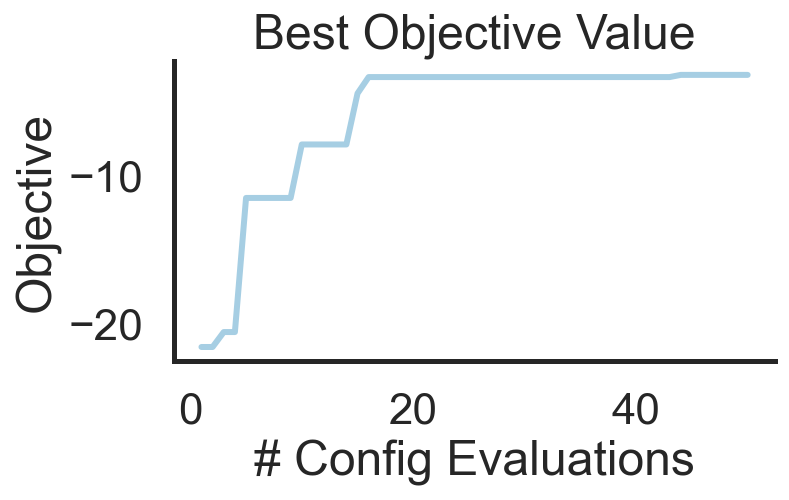

In [9]:
hyper_strategy.plot_best()